In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
import warnings

warnings.filterwarnings(action = 'ignore')

### 법정동 -> 행정동

In [166]:
def dong_change(file_name):
    sample_df = pd.read_excel(file_name)
    sample_df.drop('STD_DAY',axis=1,inplace=True)

    change_df = pd.read_excel('행정구역분류.xlsx',header=1)

    seoul_df = change_df[change_df['시도']=='서울특별시']
    seoul_df = seoul_df[seoul_df['행정구역명'].str[-1] =='동']
    seoul_df = seoul_df[['시군구','행정구역명','법정동','법정동코드','행정기관코드','법정동 관할구역\n분할여부']]
    seoul_df.columns = ['GU','DONG','법정동','DONG_CODE','행정기관코드','분할여부']
    non_div = seoul_df[seoul_df['분할여부'].isnull()][['GU','DONG','DONG_CODE','행정기관코드']]

    remove_du = non_div.drop_duplicates(['행정기관코드'])

    tmp_sample_df = sample_df.drop(['GU','DONG'],axis=1)
    con_df1 = pd.merge(tmp_sample_df,non_div,on="DONG_CODE")

    non_div_result = con_df1.groupby('행정기관코드').sum()
    non_div_result = non_div_result.drop(['DONG_CODE'],axis=1)

    non_div_result = pd.merge(non_div_result, remove_du,right_on='행정기관코드',left_index=True)
    non_div_result.drop('DONG_CODE',inplace=True,axis=1)

    non_div_result.rename(columns = {'행정기관코드':'DONG_CODE'},inplace=True)

    div_df = seoul_df[seoul_df['분할여부']=='분할연계'][['GU','DONG','DONG_CODE','행정기관코드']]

    div_dong_count = div_df.groupby('DONG_CODE').count()[['행정기관코드']]
    div_dong_count.columns = ['DONG_COUNT']

    con_df2 = pd.merge(sample_df, div_dong_count,left_on='DONG_CODE',right_index=True)
    con_df2.set_index('DONG_CODE',inplace=True)

    con_df2 = con_df2.iloc[:,3:]
    cal_df = con_df2.div(con_df2['DONG_COUNT'], axis=0) 
    div_result_df = pd.merge(div_df,cal_df,left_on='DONG_CODE',right_index=True)
    div_result_df = div_result_df.drop(['DONG_CODE','DONG_COUNT'],axis=1)
    div_result_df.rename(columns = {'행정기관코드':'DONG_CODE'},inplace=True)

    non_div_result = non_div_result[div_result_df.columns]
    result_df = pd.concat([non_div_result, div_result_df],axis=0)
    result_sum = result_df.groupby('DONG_CODE').sum()
    
    remove_result_du =result_df.drop_duplicates(['DONG_CODE'])[['GU','DONG','DONG_CODE']]
    result_df2 = pd.merge(result_sum, remove_result_du,right_on='DONG_CODE',left_index=True)

    return result_df2

### 성형외과가 강남에 많이 쏠려있어서, 일부제거

In [167]:
def ps_remove_count():
    df = pd.read_excel('HOSPITAL_DM.xlsx',sheet_name='워크시트 익스포트')
    df = df[~df['HOSPITAL_NAME'].str.contains('성형')] # 성형외과 제거
    tmp_df = df[['HOSPITAL_CODE','HOSPITAL_NAME','HOSPITAL_TYPE','ADD_STR','DONG','DONG_CODE']]
    
    std = pd.read_excel('행정구역분류.xlsx',sheet_name='행정동 및 법정동코드와의 연계표')
    std.columns = std.loc[0]
    std = std[1:]
    std_seoul = std[std['시도'] == '서울특별시']
    std_df = std_seoul[['시군구','행정동\n(행정기관명)','법정동','행정기관코드','법정동코드','법정동 관할구역\n분할여부']][1:]
    std_df.columns = ['시군구','행정동','법정동','행정기관코드','법정동코드','분할여부']
    
    data = tmp_df['DONG_CODE'].value_counts()
    x = pd.DataFrame(data)
    x.rename(columns={'DONG_CODE':'HOSPITAL_NUM'},inplace=True)
    x['DONG_CODE'] = x.index
    x.index = range(len(x))

    return x

In [168]:
df = pd.read_excel('FINAL_NUM_1029.xlsx') # 법정동 데이터
copy_df = df.copy()

ps_rm_cnt = ps_remove_count()

merge = pd.merge(copy_df,ps_rm_cnt, how='outer',on='DONG_CODE')
df = merge.fillna(0)
del(df['HOSPITAL_NUM_x'])
df.rename(columns={'HOSPITAL_NUM_y':'HOSPITAL_NUM'},inplace=True)

file_name = "법정동_성형외과_제외_data.xlsx"
df.to_excel(file_name, index=False)

In [169]:
change_df = dong_change(file_name)
change_df

,ACADEMY_NUM,KINDER_NUM,FIRE_NUM,ELE_SCH_NUM,MID_SCH_NUM,HIGH_SCH_NUM,CCTV_NUM,POLICE_NUM,BIKE_NUM,CAR_SHR_NUM,BUS_NUM,SUBWAY_NUM,SAFE_DLVR_NUM,DPTM_NUM,ANI_HSPT_NUM,PHARM_NUM,LEISURE_NUM,KIDS_NUM,SPORT_NUM,GYM_NUM,GOLF_NUM,STARBUCKS_NUM,MC_NUM,CON_NUM,NOISE_VIBRATION_NUM,CHILD_MED_NUM,CAFE_NUM,PARK_NUM,HOSPITAL_NUM,GU,DONG,DONG_CODE
2,18.000000,0.000000,1.0,2.000000,2.000000,3.0,56.666667,2.000000,5.666667,1.000000,11.666667,0.333333,1.000000,0.0,2.000000,4.333333,1.000000,0.000000,0.0,0.0,0.000000,0.333333,0.0,4.000000,18816.000000,7.333333,39.666667,1.666667,11.666667,종로구,청운효자동,1111051500
12,19.000000,10.000000,0.0,2.000000,0.000000,0.0,41.666667,3.000000,11.666667,5.000000,18.666667,1.333333,0.000000,0.0,1.000000,17.333333,1.000000,0.000000,0.0,18.0,3.000000,7.333333,0.0,20.000000,22848.000000,10.333333,100.666667,2.666667,74.666667,종로구,사직동,1111053000
24,2.000000,10.000000,0.0,0.000000,1.000000,1.0,22.000000,1.000000,7.000000,1.000000,8.000000,1.000000,0.000000,0.0,0.000000,2.000000,0.000000,0.000000,1.0,3.0,0.000000,1.000000,0.0,2.000000,14112.000000,1.000000,52.000000,1.000000,7.000000,종로구,삼청동,1111054000
31,24.000000,0.000000,1.0,4.000000,1.000000,1.0,41.000000,1.000000,5.000000,5.000000,18.000000,0.000000,0.000000,0.0,3.000000,1.000000,0.000000,0.000000,0.0,2.0,2.000000,0.000000,0.0,8.000000,6048.000000,5.000000,30.000000,1.000000,4.000000,종로구,부암동,1111055000
34,28.000000,0.000000,0.0,0.000000,0.000000,1.0,21.000000,1.000000,7.000000,0.000000,25.000000,0.000000,0.000000,0.0,0.000000,5.000000,0.000000,0.000000,0.0,5.0,5.000000,1.000000,0.0,6.000000,4032.000000,10.000000,36.000000,0.000000,14.000000,종로구,평창동,1111056000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
762,63.333333,16.666667,1.0,1.333333,0.333333,0.0,52.000000,0.333333,6.000000,6.666667,11.000000,0.333333,0.666667,0.0,2.666667,12.666667,1.666667,0.666667,0.0,10.0,4.666667,1.333333,0.0,38.666667,1442.333333,4.000000,47.666667,0.000000,59.333333,강동구,성내2동,1174065000
763,63.333333,16.666667,1.0,1.333333,0.333333,0.0,52.000000,0.333333,6.000000,6.666667,11.000000,0.333333,0.666667,0.0,2.666667,12.666667,1.666667,0.666667,0.0,10.0,4.666667,1.333333,0.0,38.666667,1442.333333,4.000000,47.666667,0.000000,59.333333,강동구,성내3동,1174066000
764,100.000000,20.000000,1.0,6.000000,1.000000,0.0,119.000000,0.000000,9.000000,10.000000,22.000000,1.000000,1.000000,0.0,8.000000,35.000000,3.000000,1.000000,0.0,18.0,9.000000,2.000000,0.0,76.000000,4327.000000,10.000000,63.000000,1.000000,120.000000,강동구,길동,1174068500
765,38.000000,0.000000,0.0,2.000000,1.500000,1.0,32.500000,1.000000,5.500000,2.000000,7.000000,0.500000,0.000000,0.0,1.500000,10.000000,0.000000,0.000000,0.0,4.0,3.000000,0.000000,0.5,17.000000,2163.500000,0.000000,17.500000,1.000000,14.500000,강동구,둔촌1동,1174069000


### 버스 데이터 누락이 많아서, 새로운 데이터로 교체

In [170]:
def add_bus_data(df):
    df.drop('BUS_NUM',axis=1,inplace=True)
    copy_df = df.copy()
    copy_df['GU_DONG'] = copy_df['GU'] + copy_df['DONG']
    
    bus_df = pd.read_csv('동별_버스정보_수정.csv')
    merge_df = pd.merge(copy_df, bus_df)
    merge_df.drop('GU_DONG',axis=1,inplace=True)
    
    return merge_df

In [100]:
change_bus_df = add_bus_data(change_df)
change_bus_df

,ACADEMY_NUM,KINDER_NUM,FIRE_NUM,ELE_SCH_NUM,MID_SCH_NUM,HIGH_SCH_NUM,CCTV_NUM,POLICE_NUM,BIKE_NUM,CAR_SHR_NUM,SUBWAY_NUM,SAFE_DLVR_NUM,DPTM_NUM,ANI_HSPT_NUM,PHARM_NUM,LEISURE_NUM,KIDS_NUM,SPORT_NUM,GYM_NUM,GOLF_NUM,STARBUCKS_NUM,MC_NUM,CON_NUM,NOISE_VIBRATION_NUM,CHILD_MED_NUM,CAFE_NUM,PARK_NUM,HOSPITAL_NUM,GU,DONG,DONG_CODE,BUS_CNT
0,18.000000,0.000000,1.0,2.000000,2.000000,3.0,56.666667,2.000000,5.666667,1.000000,0.333333,1.000000,0.0,2.000000,4.333333,1.000000,0.000000,0.0,0.0,0.000000,0.333333,0.0,4.000000,18816.000000,7.333333,39.666667,1.666667,11.666667,종로구,청운효자동,1111051500,14.0
1,19.000000,10.000000,0.0,2.000000,0.000000,0.0,41.666667,3.000000,11.666667,5.000000,1.333333,0.000000,0.0,1.000000,17.333333,1.000000,0.000000,0.0,18.0,3.000000,7.333333,0.0,20.000000,22848.000000,10.333333,100.666667,2.666667,74.666667,종로구,사직동,1111053000,16.0
2,2.000000,10.000000,0.0,0.000000,1.000000,1.0,22.000000,1.000000,7.000000,1.000000,1.000000,0.000000,0.0,0.000000,2.000000,0.000000,0.000000,1.0,3.0,0.000000,1.000000,0.0,2.000000,14112.000000,1.000000,52.000000,1.000000,7.000000,종로구,삼청동,1111054000,11.0
3,24.000000,0.000000,1.0,4.000000,1.000000,1.0,41.000000,1.000000,5.000000,5.000000,0.000000,0.000000,0.0,3.000000,1.000000,0.000000,0.000000,0.0,2.0,2.000000,0.000000,0.0,8.000000,6048.000000,5.000000,30.000000,1.000000,4.000000,종로구,부암동,1111055000,9.0
4,28.000000,0.000000,0.0,0.000000,0.000000,1.0,21.000000,1.000000,7.000000,0.000000,0.000000,0.000000,0.0,0.000000,5.000000,0.000000,0.000000,0.0,5.0,5.000000,1.000000,0.0,6.000000,4032.000000,10.000000,36.000000,0.000000,14.000000,종로구,평창동,1111056000,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,63.333333,16.666667,1.0,1.333333,0.333333,0.0,52.000000,0.333333,6.000000,6.666667,0.333333,0.666667,0.0,2.666667,12.666667,1.666667,0.666667,0.0,10.0,4.666667,1.333333,0.0,38.666667,1442.333333,4.000000,47.666667,0.000000,59.333333,강동구,성내2동,1174065000,11.0
422,63.333333,16.666667,1.0,1.333333,0.333333,0.0,52.000000,0.333333,6.000000,6.666667,0.333333,0.666667,0.0,2.666667,12.666667,1.666667,0.666667,0.0,10.0,4.666667,1.333333,0.0,38.666667,1442.333333,4.000000,47.666667,0.000000,59.333333,강동구,성내3동,1174066000,9.0
423,100.000000,20.000000,1.0,6.000000,1.000000,0.0,119.000000,0.000000,9.000000,10.000000,1.000000,1.000000,0.0,8.000000,35.000000,3.000000,1.000000,0.0,18.0,9.000000,2.000000,0.0,76.000000,4327.000000,10.000000,63.000000,1.000000,120.000000,강동구,길동,1174068500,28.0
424,38.000000,0.000000,0.0,2.000000,1.500000,1.0,32.500000,1.000000,5.500000,2.000000,0.500000,0.000000,0.0,1.500000,10.000000,0.000000,0.000000,0.0,4.0,3.000000,0.000000,0.5,17.000000,2163.500000,0.000000,17.500000,1.000000,14.500000,강동구,둔촌1동,1174069000,4.0


In [101]:
change_bus_df.columns

Index(['ACADEMY_NUM', 'KINDER_NUM', 'FIRE_NUM', 'ELE_SCH_NUM', 'MID_SCH_NUM',
       'HIGH_SCH_NUM', 'CCTV_NUM', 'POLICE_NUM', 'BIKE_NUM', 'CAR_SHR_NUM',
       'SUBWAY_NUM', 'SAFE_DLVR_NUM', 'DPTM_NUM', 'ANI_HSPT_NUM', 'PHARM_NUM',
       'LEISURE_NUM', 'KIDS_NUM', 'SPORT_NUM', 'GYM_NUM', 'GOLF_NUM',
       'STARBUCKS_NUM', 'MC_NUM', 'CON_NUM', 'NOISE_VIBRATION_NUM',
       'CHILD_MED_NUM', 'CAFE_NUM', 'PARK_NUM', 'HOSPITAL_NUM', 'GU', 'DONG',
       'DONG_CODE', 'BUS_CNT'],
      dtype='object')

In [102]:
pd.set_option('display.max_columns',35)

In [171]:
tmp_df = change_bus_df[['GU', 'DONG','DONG_CODE','ACADEMY_NUM', 'KINDER_NUM', 'FIRE_NUM', 'ELE_SCH_NUM', 'MID_SCH_NUM',
       'HIGH_SCH_NUM', 'CCTV_NUM', 'POLICE_NUM', 'BIKE_NUM', 'CAR_SHR_NUM',
       'SUBWAY_NUM', 'SAFE_DLVR_NUM', 'DPTM_NUM', 'ANI_HSPT_NUM', 'PHARM_NUM',
       'LEISURE_NUM', 'KIDS_NUM', 'SPORT_NUM', 'GYM_NUM', 'GOLF_NUM',
       'STARBUCKS_NUM', 'MC_NUM', 'CON_NUM', 'NOISE_VIBRATION_NUM',
       'CHILD_MED_NUM', 'CAFE_NUM', 'PARK_NUM', 'HOSPITAL_NUM','BUS_CNT']]


In [174]:
tmp_df3 = tmp_df.copy()

In [104]:
# 피쳐합

# 교통
tmp_df['교통'] =tmp_df['SUBWAY_NUM'] + 0.93*tmp_df['BUS_CNT']+0.06*tmp_df['BIKE_NUM']
tmp_df = tmp_df.drop(['SUBWAY_NUM','BUS_CNT','BIKE_NUM'],axis=1)

# 교육
tmp_df['교육'] =(0.07)*tmp_df['MID_SCH_NUM'] + (0.03)*tmp_df['HIGH_SCH_NUM']+tmp_df['ACADEMY_NUM'] + (0.9)*tmp_df['ELE_SCH_NUM']
tmp_df = tmp_df.drop(['MID_SCH_NUM','HIGH_SCH_NUM','ACADEMY_NUM','ELE_SCH_NUM'],axis=1)

# 육아
tmp_df['육아'] = tmp_df['KIDS_NUM'] + tmp_df['CHILD_MED_NUM']+ tmp_df['KINDER_NUM']
tmp_df = tmp_df.drop(['KIDS_NUM','CHILD_MED_NUM','KINDER_NUM'],axis=1)

# 치안
tmp_df['치안'] = tmp_df['POLICE_NUM']+tmp_df['CCTV_NUM']+tmp_df['FIRE_NUM']
tmp_df = tmp_df.drop(['POLICE_NUM','CCTV_NUM','FIRE_NUM'],axis=1)

# 건강
tmp_df['건강'] =(0.94)*tmp_df['HOSPITAL_NUM'] + tmp_df['PHARM_NUM']
tmp_df = tmp_df.drop(['HOSPITAL_NUM','PHARM_NUM'],axis=1)

# 편의시설
tmp_df['편의시설'] =0.46*tmp_df['DPTM_NUM'] + tmp_df['CON_NUM']
tmp_df = tmp_df.drop(['DPTM_NUM','CON_NUM'],axis=1)

In [105]:
tmp_df.head()

,GU,DONG,DONG_CODE,CAR_SHR_NUM,SAFE_DLVR_NUM,ANI_HSPT_NUM,LEISURE_NUM,SPORT_NUM,GYM_NUM,GOLF_NUM,STARBUCKS_NUM,MC_NUM,NOISE_VIBRATION_NUM,CAFE_NUM,PARK_NUM,교통,교육,육아,치안,건강,편의시설
0,종로구,청운효자동,1111051500,1.0,1.0,2.0,1.0,0.0,0.0,0.0,0.333333,0.0,18816.0,39.666667,1.666667,13.693333,20.03,7.333333,59.666667,15.30,4.0
1,종로구,사직동,1111053000,5.0,0.0,1.0,1.0,0.0,18.0,3.0,7.333333,0.0,22848.0,100.666667,2.666667,16.913333,20.80,20.333333,44.666667,87.52,20.0
2,종로구,삼청동,1111054000,1.0,0.0,0.0,0.0,1.0,3.0,0.0,1.000000,0.0,14112.0,52.000000,1.000000,11.650000,2.10,11.000000,23.000000,8.58,2.0
3,종로구,부암동,1111055000,5.0,0.0,3.0,0.0,0.0,2.0,2.0,0.000000,0.0,6048.0,30.000000,1.000000,8.670000,27.70,5.000000,43.000000,4.76,8.0
4,종로구,평창동,1111056000,0.0,0.0,0.0,0.0,0.0,5.0,5.0,1.000000,0.0,4032.0,36.000000,0.000000,34.830000,28.03,10.000000,22.000000,18.16,6.0


In [106]:
tmp_df.set_index('DONG_CODE',inplace=True)


In [107]:
tmp_df2 = tmp_df.copy()

In [109]:

data = tmp_df.drop(['GU','DONG'],axis=1)
# data = minmax_norm(data)
kmeans = KMeans(n_clusters=3, init='k-means++',max_iter=300,random_state=0)
kmeans.fit(data)

basic_df = tmp_df.copy()
basic_df['km_cluster'] = kmeans.labels_


In [110]:
basic_df.groupby('km_cluster').count()

,GU,DONG,CAR_SHR_NUM,SAFE_DLVR_NUM,ANI_HSPT_NUM,LEISURE_NUM,SPORT_NUM,GYM_NUM,GOLF_NUM,STARBUCKS_NUM,MC_NUM,NOISE_VIBRATION_NUM,CAFE_NUM,PARK_NUM,교통,교육,육아,치안,건강,편의시설
km_cluster,,,,,,,,,,,,,,,,,,,,
0,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39,39
1,386,386,386,386,386,386,386,386,386,386,386,386,386,386,386,386,386,386,386,386
2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [111]:
from sklearn.decomposition import PCA

basic_pca = PCA(n_components=2)
basic_pca_transformed = basic_pca.fit_transform(data)

basic_df['pca_x']=basic_pca_transformed[:,0]
basic_df['pca_y']=basic_pca_transformed[:,1]

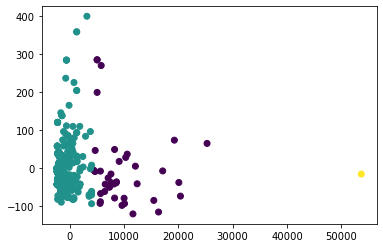

In [112]:
#  plt.xlim(-0.01,0.06)
# plt.ylim(-0.05,0.05)
plt.scatter(x=basic_df.loc[:,'pca_x'], y=basic_df.loc[:,'pca_y'],c=basic_df['km_cluster'])

In [113]:
basic_df[200 < basic_df['pca_y']]

,GU,DONG,CAR_SHR_NUM,SAFE_DLVR_NUM,ANI_HSPT_NUM,LEISURE_NUM,SPORT_NUM,GYM_NUM,GOLF_NUM,STARBUCKS_NUM,MC_NUM,NOISE_VIBRATION_NUM,CAFE_NUM,PARK_NUM,교통,교육,육아,치안,건강,편의시설,km_cluster,pca_x,pca_y
DONG_CODE,,,,,,,,,,,,,,,,,,,,,,,
1144066000,마포구,서교동,24.000000,3.500000,9.500000,15.00,0.000000,39.500000,4.000000,8.50,1.000000,8267.500000,254.5,0.00,43.850000,216.2700,18.500000,127.000000,198.500,101.000,0,5816.432242,269.391794
1156054000,영등포구,여의동,11.000000,0.000000,3.000000,0.00,0.000000,27.000000,25.000000,18.00,1.000000,3264.000000,255.0,2.00,38.330000,103.8000,150.000000,108.000000,205.800,105.460,1,812.969695,224.808008
1165053000,서초구,서초3동,12.083333,0.333333,5.833333,3.00,0.333333,39.333333,22.416667,6.75,0.916667,1744.583333,126.5,0.00,41.628333,203.9325,113.416667,64.583333,207.090,82.500,1,-707.001053,236.056624
1168051000,강남구,신사동,4.000000,0.500000,5.000000,2.00,0.000000,29.500000,14.500000,4.00,1.000000,7518.000000,130.0,0.50,26.070000,254.9500,13.500000,145.000000,264.540,66.190,0,5066.596667,284.565995
1168052100,강남구,논현1동,12.000000,0.500000,5.500000,1.00,0.000000,38.500000,24.000000,5.00,1.000000,3759.000000,135.5,0.00,8.340000,90.8350,9.000000,252.500000,216.220,102.500,1,1307.679511,203.790034
1168053100,강남구,논현2동,12.000000,0.500000,5.500000,1.00,0.000000,38.500000,24.000000,5.00,1.000000,3759.000000,135.5,0.00,5.550000,90.8350,9.000000,252.500000,216.220,102.500,1,1307.677948,203.678224
1168054500,강남구,압구정동,4.000000,0.500000,5.000000,2.00,0.000000,29.500000,14.500000,4.00,1.000000,7518.000000,130.0,0.50,13.980000,254.9500,13.500000,145.000000,264.540,66.190,0,5066.589894,284.081484
1168060000,강남구,대치1동,5.000000,0.500000,2.000000,0.25,0.000000,14.500000,13.000000,4.00,0.250000,1879.500000,62.5,0.00,11.530000,406.9175,23.000000,92.250000,83.795,42.115,1,-572.586947,283.528723
1168061000,강남구,대치2동,5.000000,0.500000,2.000000,0.25,0.000000,14.500000,13.000000,4.00,0.250000,1879.500000,62.5,0.00,18.040000,406.9175,23.000000,92.250000,83.795,42.115,1,-572.583300,283.789613


In [114]:
tmp_df.describe()

,CAR_SHR_NUM,SAFE_DLVR_NUM,ANI_HSPT_NUM,LEISURE_NUM,SPORT_NUM,GYM_NUM,GOLF_NUM,STARBUCKS_NUM,MC_NUM,NOISE_VIBRATION_NUM,CAFE_NUM,PARK_NUM,교통,교육,육아,치안,건강,편의시설
count,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000
mean,4.133803,0.622066,2.093897,1.194836,0.166667,7.448357,3.626761,1.302817,0.204225,2452.551643,37.985915,0.309859,15.812629,60.386103,36.415493,54.546948,51.924836,27.268592
std,3.156750,0.503566,1.393441,1.606980,0.567719,7.034213,4.318573,2.164240,0.363035,4534.820198,37.562957,0.457164,9.637535,56.739196,26.101509,41.269881,39.557260,19.801220
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,125.750000,2.000000,0.000000,2.070000,1.000000,0.000000,4.333333,1.940000,0.000000
25%,2.285714,0.000000,1.350000,0.000000,0.000000,3.500000,1.333333,0.333333,0.000000,442.037500,19.541667,0.000000,9.540000,28.970000,17.750000,26.589286,31.060000,17.714286
50%,3.500000,0.666667,2.000000,0.833333,0.000000,6.000000,2.500000,0.666667,0.000000,1014.000000,27.363636,0.142857,13.497000,44.300000,30.750000,42.750000,43.096667,22.500000
75%,5.000000,1.000000,2.500000,1.750000,0.000000,9.000000,4.500000,1.333333,0.285714,2163.500000,39.250000,0.500000,19.942500,73.250000,48.687500,67.075000,59.130000,29.333333
max,24.000000,3.500000,12.000000,15.000000,5.000000,60.000000,32.500000,18.500000,4.000000,56112.000000,274.000000,3.000000,73.811818,486.355000,209.000000,252.500000,289.700000,170.000000


In [115]:
basic_df[basic_df['pca_y']>350]

,GU,DONG,CAR_SHR_NUM,SAFE_DLVR_NUM,ANI_HSPT_NUM,LEISURE_NUM,SPORT_NUM,GYM_NUM,GOLF_NUM,STARBUCKS_NUM,MC_NUM,NOISE_VIBRATION_NUM,CAFE_NUM,PARK_NUM,교통,교육,육아,치안,건강,편의시설,km_cluster,pca_x,pca_y
DONG_CODE,,,,,,,,,,,,,,,,,,,,,,,
1168064000,강남구,역삼1동,19.0,1.00,7.5,5.5,0.0,45.00,32.50,12.00,1.00,3759.0,251.5,0.00,28.730,195.885,38.0,216.00,289.70,162.000,1,1308.420834,358.036675
1168065000,강남구,역삼2동,19.0,1.00,7.5,5.5,0.0,45.00,32.50,12.00,1.00,3759.0,251.5,0.00,16.640,195.885,38.0,216.00,289.70,162.000,1,1308.414060,357.552164
1168074000,강남구,일원2동,8.5,0.75,5.0,0.5,0.0,19.25,19.75,4.25,0.25,5638.5,89.0,0.25,9.305,486.355,42.5,200.25,133.09,63.115,1,3186.857758,398.809424


In [116]:
basic_df[basic_df['pca_x']>50000]

,GU,DONG,CAR_SHR_NUM,SAFE_DLVR_NUM,ANI_HSPT_NUM,LEISURE_NUM,SPORT_NUM,GYM_NUM,GOLF_NUM,STARBUCKS_NUM,MC_NUM,NOISE_VIBRATION_NUM,CAFE_NUM,PARK_NUM,교통,교육,육아,치안,건강,편의시설,km_cluster,pca_x,pca_y
DONG_CODE,,,,,,,,,,,,,,,,,,,,,,,
1111061500,종로구,종로1.2.3.4가동,18.0,0.0,0.0,4.0,0.0,10.0,5.0,13.333333,1.0,56112.0,243.166667,1.666667,50.663333,105.1,71.333333,85.666667,192.66,55.0,2,53660.032348,-15.708695


<AxesSubplot:>

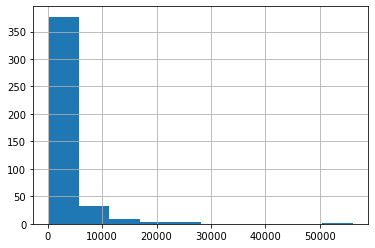

In [117]:
tmp_df['NOISE_VIBRATION_NUM'].hist()

In [189]:
def minmax_norm(df):
    empty_df = pd.DataFrame()
    for c in df.columns:
        temp_df = (df[c] - df[c].min()) / ( df[c].max() - df[c].min())
        empty_df = pd.concat([empty_df, temp_df],axis=1)

    return empty_df

In [119]:

data = tmp_df.drop(['GU','DONG'],axis=1)
data = minmax_norm(data)
kmeans = KMeans(n_clusters=3, init='k-means++',max_iter=300,random_state=0)
kmeans.fit(data)

basic_df = tmp_df.copy()
basic_df['km_cluster'] = kmeans.labels_

from sklearn.decomposition import PCA

basic_pca = PCA(n_components=2)
basic_pca_transformed = basic_pca.fit_transform(data)

basic_df['pca_x']=basic_pca_transformed[:,0]
basic_df['pca_y']=basic_pca_transformed[:,1]

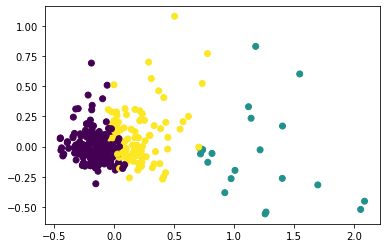

In [120]:
#  plt.xlim(-0.01,0.06)
# plt.ylim(-0.05,0.05)
plt.scatter(x=basic_df.loc[:,'pca_x'], y=basic_df.loc[:,'pca_y'],c=basic_df['km_cluster'])

In [121]:
basic_df[basic_df['pca_x']>2]

,GU,DONG,CAR_SHR_NUM,SAFE_DLVR_NUM,ANI_HSPT_NUM,LEISURE_NUM,SPORT_NUM,GYM_NUM,GOLF_NUM,STARBUCKS_NUM,MC_NUM,NOISE_VIBRATION_NUM,CAFE_NUM,PARK_NUM,교통,교육,육아,치안,건강,편의시설,km_cluster,pca_x,pca_y
DONG_CODE,,,,,,,,,,,,,,,,,,,,,,,
1168064000,강남구,역삼1동,19.0,1.0,7.5,5.5,0.0,45.0,32.5,12.0,1.0,3759.0,251.5,0.0,28.73,195.885,38.0,216.0,289.7,162.0,1,2.086642,-0.452744
1168065000,강남구,역삼2동,19.0,1.0,7.5,5.5,0.0,45.0,32.5,12.0,1.0,3759.0,251.5,0.0,16.64,195.885,38.0,216.0,289.7,162.0,1,2.054140,-0.520974


## PCA -> 군집화

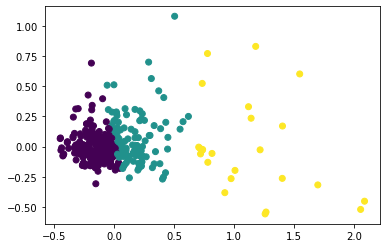

In [122]:

data = tmp_df.drop(['GU','DONG'],axis=1)
data = minmax_norm(data)
basic_pca = PCA(n_components=2)
basic_pca_transformed = basic_pca.fit_transform(data)

kmeans = KMeans(n_clusters=3, init='k-means++',max_iter=300,random_state=0)
kmeans.fit(basic_pca_transformed)

basic_df = tmp_df.copy()
basic_df['km_cluster'] = kmeans.labels_


basic_df['pca_x']=basic_pca_transformed[:,0]
basic_df['pca_y']=basic_pca_transformed[:,1]

#  plt.xlim(-0.01,0.06)
# plt.ylim(-0.05,0.05)
plt.scatter(x=basic_df.loc[:,'pca_x'], y=basic_df.loc[:,'pca_y'],c=basic_df['km_cluster'])

### 소음 카테고리화

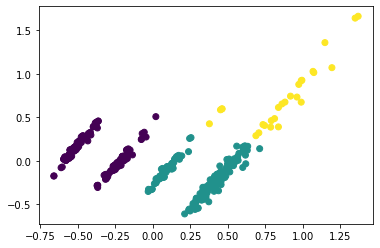

In [123]:
tmp_df['NOISE_VIBRATION_NUM'] = np.where(tmp_df['NOISE_VIBRATION_NUM'] <500, 4,(np.where(tmp_df['NOISE_VIBRATION_NUM']<=1000, 3,(np.where(tmp_df['NOISE_VIBRATION_NUM']<=1500,2,1)))))
data = tmp_df.drop(['GU','DONG'],axis=1)
data = minmax_norm(data)
basic_pca = PCA(n_components=2)
basic_pca_transformed = basic_pca.fit_transform(data)

kmeans = KMeans(n_clusters=3, init='k-means++',max_iter=300,random_state=0)
kmeans.fit(basic_pca_transformed)

basic_df = tmp_df.copy()
basic_df['km_cluster'] = kmeans.labels_


basic_df['pca_x']=basic_pca_transformed[:,0]
basic_df['pca_y']=basic_pca_transformed[:,1]

#  plt.xlim(-0.01,0.06)
# plt.ylim(-0.05,0.05)
plt.scatter(x=basic_df.loc[:,'pca_x'], y=basic_df.loc[:,'pca_y'],c=basic_df['km_cluster'])

In [124]:
basic_df[basic_df['pca_y'] >1.5]

,GU,DONG,CAR_SHR_NUM,SAFE_DLVR_NUM,ANI_HSPT_NUM,LEISURE_NUM,SPORT_NUM,GYM_NUM,GOLF_NUM,STARBUCKS_NUM,MC_NUM,NOISE_VIBRATION_NUM,CAFE_NUM,PARK_NUM,교통,교육,육아,치안,건강,편의시설,km_cluster,pca_x,pca_y
DONG_CODE,,,,,,,,,,,,,,,,,,,,,,,
1168064000,강남구,역삼1동,19.0,1.0,7.5,5.5,0.0,45.0,32.5,12.0,1.0,1,251.5,0.0,28.73,195.885,38.0,216.0,289.7,162.0,2,1.370282,1.662525
1168065000,강남구,역삼2동,19.0,1.0,7.5,5.5,0.0,45.0,32.5,12.0,1.0,1,251.5,0.0,16.64,195.885,38.0,216.0,289.7,162.0,2,1.350065,1.640859


In [125]:
tmp_df.describe()

,CAR_SHR_NUM,SAFE_DLVR_NUM,ANI_HSPT_NUM,LEISURE_NUM,SPORT_NUM,GYM_NUM,GOLF_NUM,STARBUCKS_NUM,MC_NUM,NOISE_VIBRATION_NUM,CAFE_NUM,PARK_NUM,교통,교육,육아,치안,건강,편의시설
count,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000,426.000000
mean,4.133803,0.622066,2.093897,1.194836,0.166667,7.448357,3.626761,1.302817,0.204225,2.427230,37.985915,0.309859,15.812629,60.386103,36.415493,54.546948,51.924836,27.268592
std,3.156750,0.503566,1.393441,1.606980,0.567719,7.034213,4.318573,2.164240,0.363035,1.263277,37.562957,0.457164,9.637535,56.739196,26.101509,41.269881,39.557260,19.801220
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,2.070000,1.000000,0.000000,4.333333,1.940000,0.000000
25%,2.285714,0.000000,1.350000,0.000000,0.000000,3.500000,1.333333,0.333333,0.000000,1.000000,19.541667,0.000000,9.540000,28.970000,17.750000,26.589286,31.060000,17.714286
50%,3.500000,0.666667,2.000000,0.833333,0.000000,6.000000,2.500000,0.666667,0.000000,2.000000,27.363636,0.142857,13.497000,44.300000,30.750000,42.750000,43.096667,22.500000
75%,5.000000,1.000000,2.500000,1.750000,0.000000,9.000000,4.500000,1.333333,0.285714,4.000000,39.250000,0.500000,19.942500,73.250000,48.687500,67.075000,59.130000,29.333333
max,24.000000,3.500000,12.000000,15.000000,5.000000,60.000000,32.500000,18.500000,4.000000,4.000000,274.000000,3.000000,73.811818,486.355000,209.000000,252.500000,289.700000,170.000000


In [126]:

data2 = tmp_df2.drop(['GU','DONG'],axis=1)
data2 = np.log1p(data2)
data2

,CAR_SHR_NUM,SAFE_DLVR_NUM,ANI_HSPT_NUM,LEISURE_NUM,SPORT_NUM,GYM_NUM,GOLF_NUM,STARBUCKS_NUM,MC_NUM,NOISE_VIBRATION_NUM,CAFE_NUM,PARK_NUM,교통,교육,육아,치안,건강,편의시설
DONG_CODE,,,,,,,,,,,,,,,,,,
1111051500,0.693147,0.693147,1.098612,0.693147,0.000000,0.000000,0.000000,0.287682,0.000000,9.842516,3.705409,0.980829,2.687394,3.045950,2.120264,4.105394,2.791165,1.609438
1111053000,1.791759,0.000000,0.693147,0.693147,0.000000,2.944439,1.386294,2.120264,0.000000,10.036663,4.621699,1.299283,2.885545,3.081910,3.060271,3.821369,4.483229,3.044522
1111054000,0.693147,0.000000,0.000000,0.000000,0.693147,1.386294,0.000000,0.693147,0.000000,9.554852,3.970292,0.693147,2.537657,1.131402,2.484907,3.178054,2.259678,1.098612
1111055000,1.791759,0.000000,1.386294,0.000000,0.000000,1.098612,1.098612,0.000000,0.000000,8.707648,3.433987,0.693147,2.269028,3.356897,1.791759,3.784190,1.750937,2.197225
1111056000,0.000000,0.000000,0.000000,0.000000,0.000000,1.791759,1.791759,0.693147,0.000000,8.302266,3.610918,0.000000,3.578786,3.368330,2.397895,3.135494,2.952825,1.945910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1174065000,2.036882,0.510826,1.299283,0.980829,0.000000,2.397895,1.734601,0.847298,0.000000,7.274711,3.884994,0.000000,2.478497,4.182915,3.106080,3.995138,4.240463,3.680511
1174066000,2.036882,0.510826,1.299283,0.980829,0.000000,2.397895,1.734601,0.847298,0.000000,7.274711,3.884994,0.000000,2.308898,4.182915,3.106080,3.995138,4.240463,3.680511
1174068500,2.397895,0.693147,2.197225,1.386294,0.000000,2.944439,2.302585,1.098612,0.000000,8.372861,4.158883,0.693147,3.352707,4.667863,3.465736,4.795791,5.002603,4.343805


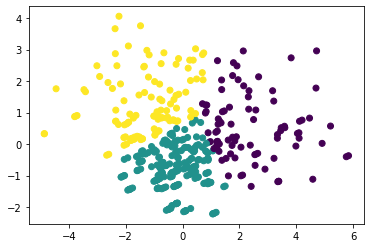

In [127]:
basic_pca = PCA(n_components=2)
basic_pca_transformed = basic_pca.fit_transform(data2)

kmeans = KMeans(n_clusters=3, init='k-means++',max_iter=300,random_state=0)
kmeans.fit(basic_pca_transformed)

basic_df = tmp_df.copy()
basic_df['km_cluster'] = kmeans.labels_


basic_df['pca_x']=basic_pca_transformed[:,0]
basic_df['pca_y']=basic_pca_transformed[:,1]

#  plt.xlim(-0.01,0.06)
# plt.ylim(-0.05,0.05)
plt.scatter(x=basic_df.loc[:,'pca_x'], y=basic_df.loc[:,'pca_y'],c=basic_df['km_cluster'])

In [128]:
basic_df.groupby('km_cluster').count()

,GU,DONG,CAR_SHR_NUM,SAFE_DLVR_NUM,ANI_HSPT_NUM,LEISURE_NUM,SPORT_NUM,GYM_NUM,GOLF_NUM,STARBUCKS_NUM,MC_NUM,NOISE_VIBRATION_NUM,CAFE_NUM,PARK_NUM,교통,교육,육아,치안,건강,편의시설,pca_x,pca_y
km_cluster,,,,,,,,,,,,,,,,,,,,,,
0,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87,87
1,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230,230
2,109,109,109,109,109,109,109,109,109,109,109,109,109,109,109,109,109,109,109,109,109,109


In [129]:

data2 = tmp_df2.drop(['GU','DONG'],axis=1)
# data2 = np.log1p(data2)
data2

,CAR_SHR_NUM,SAFE_DLVR_NUM,ANI_HSPT_NUM,LEISURE_NUM,SPORT_NUM,GYM_NUM,GOLF_NUM,STARBUCKS_NUM,MC_NUM,NOISE_VIBRATION_NUM,CAFE_NUM,PARK_NUM,교통,교육,육아,치안,건강,편의시설
DONG_CODE,,,,,,,,,,,,,,,,,,
1111051500,1.000000,1.000000,2.000000,1.000000,0.0,0.0,0.000000,0.333333,0.0,18816.000000,39.666667,1.666667,13.693333,20.030000,7.333333,59.666667,15.30,4.000000
1111053000,5.000000,0.000000,1.000000,1.000000,0.0,18.0,3.000000,7.333333,0.0,22848.000000,100.666667,2.666667,16.913333,20.800000,20.333333,44.666667,87.52,20.000000
1111054000,1.000000,0.000000,0.000000,0.000000,1.0,3.0,0.000000,1.000000,0.0,14112.000000,52.000000,1.000000,11.650000,2.100000,11.000000,23.000000,8.58,2.000000
1111055000,5.000000,0.000000,3.000000,0.000000,0.0,2.0,2.000000,0.000000,0.0,6048.000000,30.000000,1.000000,8.670000,27.700000,5.000000,43.000000,4.76,8.000000
1111056000,0.000000,0.000000,0.000000,0.000000,0.0,5.0,5.000000,1.000000,0.0,4032.000000,36.000000,0.000000,34.830000,28.030000,10.000000,22.000000,18.16,6.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1174065000,6.666667,0.666667,2.666667,1.666667,0.0,10.0,4.666667,1.333333,0.0,1442.333333,47.666667,0.000000,10.923333,64.556667,21.333333,53.333333,68.44,38.666667
1174066000,6.666667,0.666667,2.666667,1.666667,0.0,10.0,4.666667,1.333333,0.0,1442.333333,47.666667,0.000000,9.063333,64.556667,21.333333,53.333333,68.44,38.666667
1174068500,10.000000,1.000000,8.000000,3.000000,0.0,18.0,9.000000,2.000000,0.0,4327.000000,63.000000,1.000000,27.580000,105.470000,31.000000,120.000000,147.80,76.000000


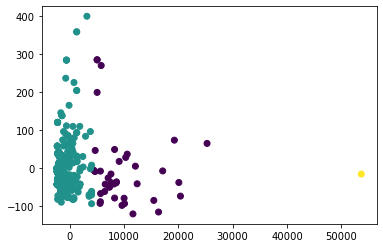

In [130]:
basic_pca = PCA(n_components=2)
basic_pca_transformed = basic_pca.fit_transform(data2)

kmeans = KMeans(n_clusters=3, init='k-means++',max_iter=300,random_state=0)
kmeans.fit(basic_pca_transformed)

basic_df = tmp_df.copy()
basic_df['km_cluster'] = kmeans.labels_


basic_df['pca_x']=basic_pca_transformed[:,0]
basic_df['pca_y']=basic_pca_transformed[:,1]

#  plt.xlim(-0.01,0.06)
# plt.ylim(-0.05,0.05)
plt.scatter(x=basic_df.loc[:,'pca_x'], y=basic_df.loc[:,'pca_y'],c=basic_df['km_cluster'])

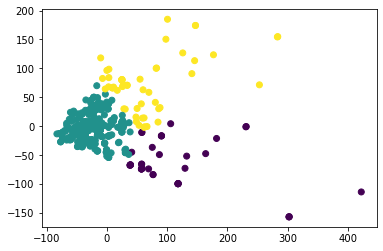

In [131]:

data2 = tmp_df2.drop(['GU','DONG'],axis=1)
data2['NOISE_VIBRATION_NUM'] = np.log1p(data2['NOISE_VIBRATION_NUM'])
data2['건강'] = np.log1p(data2['건강'])
basic_pca = PCA(n_components=2)
basic_pca_transformed = basic_pca.fit_transform(data2)

kmeans = KMeans(n_clusters=3, init='k-means++',max_iter=300,random_state=0)
kmeans.fit(basic_pca_transformed)

basic_df = tmp_df.copy()
basic_df['km_cluster'] = kmeans.labels_


basic_df['pca_x']=basic_pca_transformed[:,0]
basic_df['pca_y']=basic_pca_transformed[:,1]

#  plt.xlim(-0.01,0.06)
# plt.ylim(-0.05,0.05)
plt.scatter(x=basic_df.loc[:,'pca_x'], y=basic_df.loc[:,'pca_y'],c=basic_df['km_cluster'])

In [132]:
basic_df[basic_df['pca_x'] > 250]

,GU,DONG,CAR_SHR_NUM,SAFE_DLVR_NUM,ANI_HSPT_NUM,LEISURE_NUM,SPORT_NUM,GYM_NUM,GOLF_NUM,STARBUCKS_NUM,MC_NUM,NOISE_VIBRATION_NUM,CAFE_NUM,PARK_NUM,교통,교육,육아,치안,건강,편의시설,km_cluster,pca_x,pca_y
DONG_CODE,,,,,,,,,,,,,,,,,,,,,,,
1144066000,마포구,서교동,24.0,3.50,9.5,15.00,0.0,39.50,4.00,8.50,1.00,1,254.5,0.00,43.850,216.2700,18.5,127.00,198.500,101.000,2,253.241020,71.314790
1168060000,강남구,대치1동,5.0,0.50,2.0,0.25,0.0,14.50,13.00,4.00,0.25,1,62.5,0.00,11.530,406.9175,23.0,92.25,83.795,42.115,0,302.477178,-157.392684
1168061000,강남구,대치2동,5.0,0.50,2.0,0.25,0.0,14.50,13.00,4.00,0.25,1,62.5,0.00,18.040,406.9175,23.0,92.25,83.795,42.115,0,302.810174,-157.111004
1168063000,강남구,대치4동,5.0,0.50,2.0,0.25,0.0,14.50,13.00,4.00,0.25,1,62.5,0.00,8.740,406.9175,23.0,92.25,83.795,42.115,0,302.334466,-157.513404
1168064000,강남구,역삼1동,19.0,1.00,7.5,5.50,0.0,45.00,32.50,12.00,1.00,1,251.5,0.00,28.730,195.8850,38.0,216.00,289.700,162.000,2,283.748310,154.808426
1168065000,강남구,역삼2동,19.0,1.00,7.5,5.50,0.0,45.00,32.50,12.00,1.00,1,251.5,0.00,16.640,195.8850,38.0,216.00,289.700,162.000,2,283.129890,154.285306
1168074000,강남구,일원2동,8.5,0.75,5.0,0.50,0.0,19.25,19.75,4.25,0.25,1,89.0,0.25,9.305,486.3550,42.5,200.25,133.090,63.115,0,422.398701,-114.257546


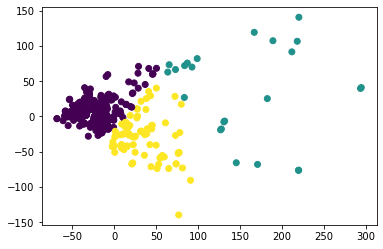

In [133]:

data2 = tmp_df2.drop(['GU','DONG'],axis=1)
data2['NOISE_VIBRATION_NUM'] = np.log1p(data2['NOISE_VIBRATION_NUM'])
data2['건강'] = np.log1p(data2['건강'])
data2['교육'] = np.log1p(data2['교육'])
basic_pca = PCA(n_components=2)
basic_pca_transformed = basic_pca.fit_transform(data2)

kmeans = KMeans(n_clusters=3, init='k-means++',max_iter=300,random_state=0)
kmeans.fit(basic_pca_transformed)

basic_df = tmp_df.copy()
basic_df['km_cluster'] = kmeans.labels_


basic_df['pca_x']=basic_pca_transformed[:,0]
basic_df['pca_y']=basic_pca_transformed[:,1]

#  plt.xlim(-0.01,0.06)
# plt.ylim(-0.05,0.05)
plt.scatter(x=basic_df.loc[:,'pca_x'], y=basic_df.loc[:,'pca_y'],c=basic_df['km_cluster'])

In [134]:
basic_df[basic_df['pca_x'] > 250]

,GU,DONG,CAR_SHR_NUM,SAFE_DLVR_NUM,ANI_HSPT_NUM,LEISURE_NUM,SPORT_NUM,GYM_NUM,GOLF_NUM,STARBUCKS_NUM,MC_NUM,NOISE_VIBRATION_NUM,CAFE_NUM,PARK_NUM,교통,교육,육아,치안,건강,편의시설,km_cluster,pca_x,pca_y
DONG_CODE,,,,,,,,,,,,,,,,,,,,,,,
1168064000,강남구,역삼1동,19.0,1.0,7.5,5.5,0.0,45.0,32.5,12.0,1.0,1,251.5,0.0,28.73,195.885,38.0,216.0,289.7,162.0,1,294.171956,40.981158
1168065000,강남구,역삼2동,19.0,1.0,7.5,5.5,0.0,45.0,32.5,12.0,1.0,1,251.5,0.0,16.64,195.885,38.0,216.0,289.7,162.0,1,293.258237,39.764318


In [135]:
basic_df[basic_df['pca_y'] > 100]

,GU,DONG,CAR_SHR_NUM,SAFE_DLVR_NUM,ANI_HSPT_NUM,LEISURE_NUM,SPORT_NUM,GYM_NUM,GOLF_NUM,STARBUCKS_NUM,MC_NUM,NOISE_VIBRATION_NUM,CAFE_NUM,PARK_NUM,교통,교육,육아,치안,건강,편의시설,km_cluster,pca_x,pca_y
DONG_CODE,,,,,,,,,,,,,,,,,,,,,,,
1111061500,종로구,종로1.2.3.4가동,18.0,0.0,0.0,4.0,0.0,10.0,5.0,13.333333,1.0,1,243.166667,1.666667,50.663333,105.100,71.333333,85.666667,192.66,55.00,1,166.614568,119.409384
1114055000,중구,명동,7.0,1.0,0.0,1.0,0.0,18.0,3.0,18.500000,3.0,1,274.000000,0.500000,32.320000,19.615,44.000000,124.500000,177.00,88.46,1,217.867617,106.713402
1154551000,금천구,가산동,19.0,1.0,1.0,8.0,0.0,24.0,13.0,9.000000,4.0,1,212.000000,0.000000,71.580000,36.000,33.000000,94.000000,98.08,170.00,1,188.895882,107.470279
1156054000,영등포구,여의동,11.0,0.0,3.0,0.0,0.0,27.0,25.0,18.000000,1.0,1,255.000000,2.000000,38.330000,103.800,150.000000,108.000000,205.80,105.46,1,219.828790,140.810708


In [136]:
basic_df['편의시설'].describe()

count    426.000000
mean      27.268592
std       19.801220
min        0.000000
25%       17.714286
50%       22.500000
75%       29.333333
max      170.000000
Name: 편의시설, dtype: float64

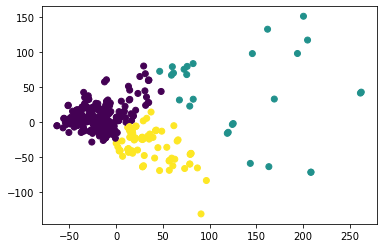

In [137]:

data2 = tmp_df2.drop(['GU','DONG'],axis=1)
data2['NOISE_VIBRATION_NUM'] = np.log1p(data2['NOISE_VIBRATION_NUM'])
data2['건강'] = np.log1p(data2['건강'])
data2['교육'] = np.log1p(data2['교육'])
data2['편의시설'] = np.log1p(data2['편의시설'])
basic_pca = PCA(n_components=2)
basic_pca_transformed = basic_pca.fit_transform(data2)

kmeans = KMeans(n_clusters=3, init='k-means++',max_iter=300,random_state=0)
kmeans.fit(basic_pca_transformed)

basic_df = tmp_df.copy()
basic_df['km_cluster'] = kmeans.labels_


basic_df['pca_x']=basic_pca_transformed[:,0]
basic_df['pca_y']=basic_pca_transformed[:,1]

#  plt.xlim(-0.01,0.06)
# plt.ylim(-0.05,0.05)
plt.scatter(x=basic_df.loc[:,'pca_x'], y=basic_df.loc[:,'pca_y'],c=basic_df['km_cluster'])

In [158]:

data2 = tmp_df2.drop(['GU','DONG'],axis=1)
from sklearn.preprocessing import RobustScaler
robust_scaler = RobustScaler()

# 훈련데이터의 모수 분포 저장
robust_scaler.fit(data2)

# 훈련 데이터 스케일링
data2 = robust_scaler.transform(data2)


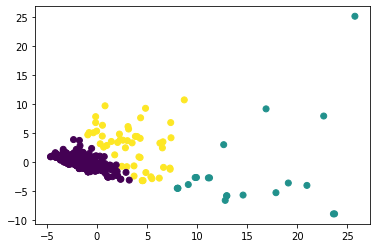

In [159]:

basic_pca = PCA(n_components=2)
basic_pca_transformed = basic_pca.fit_transform(data2)

kmeans = KMeans(n_clusters=3, init='k-means++',max_iter=300,random_state=0)
kmeans.fit(basic_pca_transformed)

basic_df = tmp_df.copy()
basic_df['km_cluster'] = kmeans.labels_


basic_df['pca_x']=basic_pca_transformed[:,0]
basic_df['pca_y']=basic_pca_transformed[:,1]

#  plt.xlim(-0.01,0.06)
# plt.ylim(-0.05,0.05)
plt.scatter(x=basic_df.loc[:,'pca_x'], y=basic_df.loc[:,'pca_y'],c=basic_df['km_cluster'])

In [160]:
basic_df[basic_df['pca_x']>25]

,GU,DONG,CAR_SHR_NUM,SAFE_DLVR_NUM,ANI_HSPT_NUM,LEISURE_NUM,SPORT_NUM,GYM_NUM,GOLF_NUM,STARBUCKS_NUM,MC_NUM,NOISE_VIBRATION_NUM,CAFE_NUM,PARK_NUM,교통,교육,육아,치안,건강,편의시설,km_cluster,pca_x,pca_y
DONG_CODE,,,,,,,,,,,,,,,,,,,,,,,
1111061500,종로구,종로1.2.3.4가동,18.0,0.0,0.0,4.0,0.0,10.0,5.0,13.333333,1.0,1,243.166667,1.666667,50.663333,105.1,71.333333,85.666667,192.66,55.0,1,25.770275,25.187489


In [241]:
density_df = pd.read_excel('인구밀도.xlsx')


In [242]:
# 행정동 데이터, 밀도 데이터 병합
tmp = pd.merge(tmp_df3, density_df)

# 컬럼 순서 정렬
tmp = tmp[['GU','DONG','DONG_CODE','POP','AREA','DENSITY',\
           'SUBWAY_NUM','BUS_CNT','BIKE_NUM',\
           'POLICE_NUM','FIRE_NUM','CCTV_NUM',\
           'HOSPITAL_NUM','PHARM_NUM',\
           'DPTM_NUM','CON_NUM','CAFE_NUM',\
           'ELE_SCH_NUM','MID_SCH_NUM','HIGH_SCH_NUM','ACADEMY_NUM',\
           'KINDER_NUM','CHILD_MED_NUM',\
           'KIDS_NUM','STARBUCKS_NUM','MC_NUM','NOISE_VIBRATION_NUM','SAFE_DLVR_NUM','LEISURE_NUM','SPORT_NUM','GYM_NUM','GOLF_NUM','CAR_SHR_NUM','ANI_HSPT_NUM']]


In [243]:
# 불필요 컬럼 제거
tmp = tmp.drop(['SPORT_NUM'],axis=1)

In [244]:
# 피쳐합
tmp_df = tmp.copy()
# 교통
tmp_df['교통'] =tmp_df['SUBWAY_NUM'] + 0.93*tmp_df['BUS_CNT']+0.06*tmp_df['BIKE_NUM']
tmp_df = tmp_df.drop(['SUBWAY_NUM','BUS_CNT','BIKE_NUM'],axis=1)

# 교육
tmp_df['교육'] =(0.07)*tmp_df['MID_SCH_NUM'] + (0.03)*tmp_df['HIGH_SCH_NUM']+tmp_df['ACADEMY_NUM'] + (0.9)*tmp_df['ELE_SCH_NUM']
tmp_df = tmp_df.drop(['MID_SCH_NUM','HIGH_SCH_NUM','ACADEMY_NUM','ELE_SCH_NUM'],axis=1)

# 육아
tmp_df['육아'] = tmp_df['KIDS_NUM'] + tmp_df['CHILD_MED_NUM']+ tmp_df['KINDER_NUM']
tmp_df = tmp_df.drop(['KIDS_NUM','CHILD_MED_NUM','KINDER_NUM'],axis=1)

# 치안
tmp_df['치안'] = tmp_df['POLICE_NUM']+tmp_df['CCTV_NUM']+tmp_df['FIRE_NUM']
tmp_df = tmp_df.drop(['POLICE_NUM','CCTV_NUM','FIRE_NUM'],axis=1)

# 건강
tmp_df['건강'] =(0.94)*tmp_df['HOSPITAL_NUM'] + tmp_df['PHARM_NUM']
tmp_df = tmp_df.drop(['HOSPITAL_NUM','PHARM_NUM'],axis=1)

# 편의시설
tmp_df['편의시설'] =0.46*tmp_df['DPTM_NUM'] + tmp_df['CON_NUM']
tmp_df = tmp_df.drop(['DPTM_NUM','CON_NUM'],axis=1)


In [245]:
tmp_df.set_index('DONG_CODE',inplace=True)

In [246]:
tmp_data = tmp_df.iloc[:,5:]
tmp_data

,CAFE_NUM,STARBUCKS_NUM,MC_NUM,NOISE_VIBRATION_NUM,SAFE_DLVR_NUM,LEISURE_NUM,GYM_NUM,GOLF_NUM,CAR_SHR_NUM,ANI_HSPT_NUM,교통,교육,육아,치안,건강,편의시설
DONG_CODE,,,,,,,,,,,,,,,,
1111051500,39.666667,0.333333,0.0,18816.000000,1.000000,1.000000,0.0,0.000000,1.000000,2.000000,13.693333,20.030000,7.333333,59.666667,15.30,4.000000
1111053000,100.666667,7.333333,0.0,22848.000000,0.000000,1.000000,18.0,3.000000,5.000000,1.000000,16.913333,20.800000,20.333333,44.666667,87.52,20.000000
1111054000,52.000000,1.000000,0.0,14112.000000,0.000000,0.000000,3.0,0.000000,1.000000,0.000000,11.650000,2.100000,11.000000,23.000000,8.58,2.000000
1111055000,30.000000,0.000000,0.0,6048.000000,0.000000,0.000000,2.0,2.000000,5.000000,3.000000,8.670000,27.700000,5.000000,43.000000,4.76,8.000000
1111056000,36.000000,1.000000,0.0,4032.000000,0.000000,0.000000,5.0,5.000000,0.000000,0.000000,34.830000,28.030000,10.000000,22.000000,18.16,6.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1174065000,47.666667,1.333333,0.0,1442.333333,0.666667,1.666667,10.0,4.666667,6.666667,2.666667,10.923333,64.556667,21.333333,53.333333,68.44,38.666667
1174066000,47.666667,1.333333,0.0,1442.333333,0.666667,1.666667,10.0,4.666667,6.666667,2.666667,9.063333,64.556667,21.333333,53.333333,68.44,38.666667
1174068500,63.000000,2.000000,0.0,4327.000000,1.000000,3.000000,18.0,9.000000,10.000000,8.000000,27.580000,105.470000,31.000000,120.000000,147.80,76.000000


In [247]:
density_data = tmp_data.div(tmp_df['AREA'], axis=0)
density_data

,CAFE_NUM,STARBUCKS_NUM,MC_NUM,NOISE_VIBRATION_NUM,SAFE_DLVR_NUM,LEISURE_NUM,GYM_NUM,GOLF_NUM,CAR_SHR_NUM,ANI_HSPT_NUM,교통,교육,육아,치안,건강,편의시설
DONG_CODE,,,,,,,,,,,,,,,,
1111051500,15.434501,0.129702,0.000000,7321.400778,0.389105,0.389105,0.000000,0.000000,0.389105,0.778210,5.328145,7.793774,2.853437,23.216602,5.953307,1.556420
1111053000,81.842818,5.962060,0.000000,18575.609756,0.000000,0.813008,14.634146,2.439024,4.065041,0.813008,13.750678,16.910569,16.531165,36.314363,71.154472,16.260163
1111054000,34.899329,0.671141,0.000000,9471.140940,0.000000,0.000000,2.013423,0.000000,0.671141,0.000000,7.818792,1.409396,7.382550,15.436242,5.758389,1.342282
1111055000,13.215859,0.000000,0.000000,2664.317181,0.000000,0.000000,0.881057,0.881057,2.202643,1.321586,3.819383,12.202643,2.202643,18.942731,2.096916,3.524229
1111056000,4.058625,0.112740,0.000000,454.565953,0.000000,0.000000,0.563698,0.563698,0.000000,0.000000,3.926719,3.160090,1.127396,2.480271,2.047351,0.676437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1174065000,71.144279,1.990050,0.000000,2152.736318,0.995025,2.487562,14.925373,6.965174,9.950249,3.980100,16.303483,96.353234,31.840796,79.601990,102.149254,57.711443
1174066000,67.136150,1.877934,0.000000,2031.455399,0.938967,2.347418,14.084507,6.572770,9.389671,3.755869,12.765258,90.924883,30.046948,75.117371,96.394366,54.460094
1174068500,29.032258,0.921659,0.000000,1994.009217,0.460829,1.382488,8.294931,4.147465,4.608295,3.686636,12.709677,48.603687,14.285714,55.299539,68.110599,35.023041


In [248]:
density_data['NOISE_VIBRATION_NUM'] = np.where(density_data['NOISE_VIBRATION_NUM'] <500, 4,(np.where(density_data['NOISE_VIBRATION_NUM']<=1000, 3,(np.where(density_data['NOISE_VIBRATION_NUM']<=1500,2,1)))))
density_data['STARBUCKS_NUM'] = np.log1p(density_data['STARBUCKS_NUM'])
density_data['건강'] = np.log1p(density_data['건강'])

## 면적나누기 + minmax

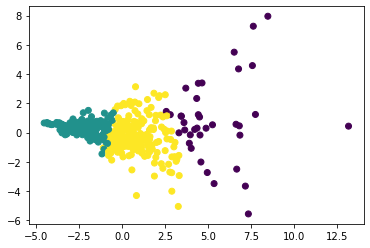

In [262]:

robust_scaler = RobustScaler()

robust_scaler.fit(density_data)

robust_data = robust_scaler.transform(density_data)

# density_data = minmax_norm(density_data)
kmeans = KMeans(n_clusters=3, init='k-means++',max_iter=400,random_state=0)
kmeans.fit(robust_data)

basic_df = tmp_df.copy()
basic_df['km_cluster'] = kmeans.labels_

from sklearn.decomposition import PCA

basic_pca = PCA(n_components=2)
basic_pca_transformed = basic_pca.fit_transform(robust_data)

basic_df['pca_x']=basic_pca_transformed[:,0]
basic_df['pca_y']=basic_pca_transformed[:,1]

plt.scatter(x=basic_df.loc[:,'pca_x'], y=basic_df.loc[:,'pca_y'],c=basic_df['km_cluster'])


In [258]:
basic_df[basic_df['pca_x'] > 10]

,GU,DONG,POP,AREA,DENSITY,CAFE_NUM,STARBUCKS_NUM,MC_NUM,NOISE_VIBRATION_NUM,SAFE_DLVR_NUM,LEISURE_NUM,GYM_NUM,GOLF_NUM,CAR_SHR_NUM,ANI_HSPT_NUM,교통,교육,육아,치안,건강,편의시설,km_cluster,pca_x,pca_y
DONG_CODE,,,,,,,,,,,,,,,,,,,,,,,,
1168065000,강남구,역삼2동,36378,1.15,31633,251.5,12.0,1.0,3759.0,1.0,5.5,45.0,32.5,19.0,7.5,16.64,195.885,38.0,216.0,289.7,162.0,0,13.170748,0.439147


<AxesSubplot:>

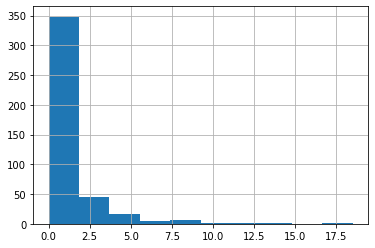

In [349]:
# coliving = pd.read_excel("코리빙(전지점).xlsx")
# coliving['구'] = coliving['위치'].str.split(' ').str[0]
# coliving['동'] = coliving['위치'].str.split(' ').str[1]
# coliving

In [348]:
# coliving.groupby('위치').count()

In [347]:
# tmp_df3['DONG'].values

In [330]:
coliving = pd.read_excel('코리빙(전지점)_최종.xlsx')
coliving['구'] = coliving['위치'].str.split(' ').str[0]
coliving['동'] = coliving['위치'].str.split(' ').str[1]

In [331]:
cnt_co = coliving.groupby("위치").count()[['동']]

cnt_co.columns=['cnt']

cnt_co.shape

(47, 1)

In [335]:
unique_dong = change_bus_df[['GU','DONG','DONG_CODE']]
unique_dong['위치'] = unique_dong['GU'] +" " +  unique_dong['DONG']

In [334]:
# a = pd.merge(unique_dong, cnt_co, on='위치')
# set(cnt_co.index) - set(a['위치']) 

In [340]:
coliving_cnt_df = pd.merge(unique_dong, cnt_co, on='위치',how='left')
coliving_cnt_df = coliving_cnt_df.fillna(0)
coliving_cnt_df.drop('위치',axis=1, inplace=True)

array([[<AxesSubplot:title={'center':'DONG_CODE'}>,
        <AxesSubplot:title={'center':'cnt'}>]], dtype=object)

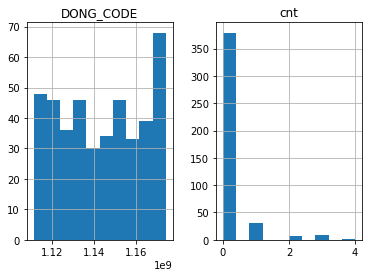

In [344]:
coliving_cnt_df.hist()

In [345]:
coliving_cnt_df

,GU,DONG,DONG_CODE,cnt
0,종로구,청운효자동,1111051500,0.0
1,종로구,사직동,1111053000,1.0
2,종로구,삼청동,1111054000,0.0
3,종로구,부암동,1111055000,0.0
4,종로구,평창동,1111056000,0.0
...,...,...,...,...
421,강동구,성내2동,1174065000,0.0
422,강동구,성내3동,1174066000,0.0
423,강동구,길동,1174068500,0.0
424,강동구,둔촌1동,1174069000,0.0


In [346]:
coliving_cnt_df.to_csv("coliving_행정동.csv")

In [350]:
density_data

,CAFE_NUM,STARBUCKS_NUM,MC_NUM,NOISE_VIBRATION_NUM,SAFE_DLVR_NUM,LEISURE_NUM,GYM_NUM,GOLF_NUM,CAR_SHR_NUM,ANI_HSPT_NUM,교통,교육,육아,치안,건강,편의시설
DONG_CODE,,,,,,,,,,,,,,,,
1111051500,15.434501,0.121954,0.000000,1,0.389105,0.389105,0.000000,0.000000,0.389105,0.778210,5.328145,7.793774,2.853437,23.216602,1.939217,1.556420
1111053000,81.842818,1.940475,0.000000,1,0.000000,0.813008,14.634146,2.439024,4.065041,0.813008,13.750678,16.910569,16.531165,36.314363,4.278809,16.260163
1111054000,34.899329,0.513507,0.000000,1,0.000000,0.000000,2.013423,0.000000,0.671141,0.000000,7.818792,1.409396,7.382550,15.436242,1.910785,1.342282
1111055000,13.215859,0.000000,0.000000,1,0.000000,0.000000,0.881057,0.881057,2.202643,1.321586,3.819383,12.202643,2.202643,18.942731,1.130407,3.524229
1111056000,4.058625,0.106825,0.000000,4,0.000000,0.000000,0.563698,0.563698,0.000000,0.000000,3.926719,3.160090,1.127396,2.480271,1.114273,0.676437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1174065000,71.144279,1.095290,0.000000,1,0.995025,2.487562,14.925373,6.965174,9.950249,3.980100,16.303483,96.353234,31.840796,79.601990,4.636177,57.711443
1174066000,67.136150,1.057073,0.000000,1,0.938967,2.347418,14.084507,6.572770,9.389671,3.755869,12.765258,90.924883,30.046948,75.117371,4.578768,54.460094
1174068500,29.032258,0.653189,0.000000,1,0.460829,1.382488,8.294931,4.147465,4.608295,3.686636,12.709677,48.603687,14.285714,55.299539,4.235708,35.023041


In [352]:
add_co_df = pd.merge(coliving_cnt_df,tmp_df3)
add_co_df.head()

,GU,DONG,DONG_CODE,cnt,ACADEMY_NUM,KINDER_NUM,FIRE_NUM,ELE_SCH_NUM,MID_SCH_NUM,HIGH_SCH_NUM,CCTV_NUM,POLICE_NUM,BIKE_NUM,CAR_SHR_NUM,SUBWAY_NUM,SAFE_DLVR_NUM,DPTM_NUM,ANI_HSPT_NUM,PHARM_NUM,LEISURE_NUM,KIDS_NUM,SPORT_NUM,GYM_NUM,GOLF_NUM,STARBUCKS_NUM,MC_NUM,CON_NUM,NOISE_VIBRATION_NUM,CHILD_MED_NUM,CAFE_NUM,PARK_NUM,HOSPITAL_NUM,BUS_CNT
0,종로구,청운효자동,1111051500,0.0,18.0,0.0,1.0,2.0,2.0,3.0,56.666667,2.0,5.666667,1.0,0.333333,1.0,0.0,2.0,4.333333,1.0,0.0,0.0,0.0,0.0,0.333333,0.0,4.0,18816.0,7.333333,39.666667,1.666667,11.666667,14.0
1,종로구,사직동,1111053000,1.0,19.0,10.0,0.0,2.0,0.0,0.0,41.666667,3.0,11.666667,5.0,1.333333,0.0,0.0,1.0,17.333333,1.0,0.0,0.0,18.0,3.0,7.333333,0.0,20.0,22848.0,10.333333,100.666667,2.666667,74.666667,16.0
2,종로구,삼청동,1111054000,0.0,2.0,10.0,0.0,0.0,1.0,1.0,22.000000,1.0,7.000000,1.0,1.000000,0.0,0.0,0.0,2.000000,0.0,0.0,1.0,3.0,0.0,1.000000,0.0,2.0,14112.0,1.000000,52.000000,1.000000,7.000000,11.0
3,종로구,부암동,1111055000,0.0,24.0,0.0,1.0,4.0,1.0,1.0,41.000000,1.0,5.000000,5.0,0.000000,0.0,0.0,3.0,1.000000,0.0,0.0,0.0,2.0,2.0,0.000000,0.0,8.0,6048.0,5.000000,30.000000,1.000000,4.000000,9.0
4,종로구,평창동,1111056000,0.0,28.0,0.0,0.0,0.0,0.0,1.0,21.000000,1.0,7.000000,0.0,0.000000,0.0,0.0,0.0,5.000000,0.0,0.0,0.0,5.0,5.0,1.000000,0.0,6.0,4032.0,10.000000,36.000000,0.000000,14.000000,37.0


In [356]:
# 행정동 데이터, 밀도 데이터 병합
tmp = pd.merge(add_co_df, density_df)

# 컬럼 순서 정렬
tmp = tmp[['GU','DONG','DONG_CODE','POP','AREA','DENSITY','cnt',\
           'SUBWAY_NUM','BUS_CNT','BIKE_NUM',\
           'POLICE_NUM','FIRE_NUM','CCTV_NUM',\
           'HOSPITAL_NUM','PHARM_NUM',\
           'DPTM_NUM','CON_NUM','CAFE_NUM',\
           'ELE_SCH_NUM','MID_SCH_NUM','HIGH_SCH_NUM','ACADEMY_NUM',\
           'KINDER_NUM','CHILD_MED_NUM',\
           'KIDS_NUM','STARBUCKS_NUM','MC_NUM','NOISE_VIBRATION_NUM','SAFE_DLVR_NUM','LEISURE_NUM','SPORT_NUM','GYM_NUM','GOLF_NUM','CAR_SHR_NUM','ANI_HSPT_NUM']]


In [357]:
# 피쳐합
tmp_df = tmp.copy()
# 교통
tmp_df['교통'] =tmp_df['SUBWAY_NUM'] + 0.93*tmp_df['BUS_CNT']+0.06*tmp_df['BIKE_NUM']
tmp_df = tmp_df.drop(['SUBWAY_NUM','BUS_CNT','BIKE_NUM'],axis=1)

# 교육
tmp_df['교육'] =(0.07)*tmp_df['MID_SCH_NUM'] + (0.03)*tmp_df['HIGH_SCH_NUM']+tmp_df['ACADEMY_NUM'] + (0.9)*tmp_df['ELE_SCH_NUM']
tmp_df = tmp_df.drop(['MID_SCH_NUM','HIGH_SCH_NUM','ACADEMY_NUM','ELE_SCH_NUM'],axis=1)

# 육아
tmp_df['육아'] = tmp_df['KIDS_NUM'] + tmp_df['CHILD_MED_NUM']+ tmp_df['KINDER_NUM']
tmp_df = tmp_df.drop(['KIDS_NUM','CHILD_MED_NUM','KINDER_NUM'],axis=1)

# 치안
tmp_df['치안'] = tmp_df['POLICE_NUM']+tmp_df['CCTV_NUM']+tmp_df['FIRE_NUM']
tmp_df = tmp_df.drop(['POLICE_NUM','CCTV_NUM','FIRE_NUM'],axis=1)

# 건강
tmp_df['건강'] =(0.94)*tmp_df['HOSPITAL_NUM'] + tmp_df['PHARM_NUM']
tmp_df = tmp_df.drop(['HOSPITAL_NUM','PHARM_NUM'],axis=1)

# 편의시설
tmp_df['편의시설'] =0.46*tmp_df['DPTM_NUM'] + tmp_df['CON_NUM']
tmp_df = tmp_df.drop(['DPTM_NUM','CON_NUM'],axis=1)

tmp_df.set_index('DONG_CODE',inplace=True)
tmp_data = tmp_df.iloc[:,5:]


In [358]:
density_data = tmp_data.div(tmp_df['AREA'], axis=0)
density_data

,cnt,CAFE_NUM,STARBUCKS_NUM,MC_NUM,NOISE_VIBRATION_NUM,SAFE_DLVR_NUM,LEISURE_NUM,SPORT_NUM,GYM_NUM,GOLF_NUM,CAR_SHR_NUM,ANI_HSPT_NUM,교통,교육,육아,치안,건강,편의시설
DONG_CODE,,,,,,,,,,,,,,,,,,
1111051500,0.000000,15.434501,0.129702,0.000000,7321.400778,0.389105,0.389105,0.000000,0.000000,0.000000,0.389105,0.778210,5.328145,7.793774,2.853437,23.216602,5.953307,1.556420
1111053000,0.813008,81.842818,5.962060,0.000000,18575.609756,0.000000,0.813008,0.000000,14.634146,2.439024,4.065041,0.813008,13.750678,16.910569,16.531165,36.314363,71.154472,16.260163
1111054000,0.000000,34.899329,0.671141,0.000000,9471.140940,0.000000,0.000000,0.671141,2.013423,0.000000,0.671141,0.000000,7.818792,1.409396,7.382550,15.436242,5.758389,1.342282
1111055000,0.000000,13.215859,0.000000,0.000000,2664.317181,0.000000,0.000000,0.000000,0.881057,0.881057,2.202643,1.321586,3.819383,12.202643,2.202643,18.942731,2.096916,3.524229
1111056000,0.000000,4.058625,0.112740,0.000000,454.565953,0.000000,0.000000,0.000000,0.563698,0.563698,0.000000,0.000000,3.926719,3.160090,1.127396,2.480271,2.047351,0.676437
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1174065000,0.000000,71.144279,1.990050,0.000000,2152.736318,0.995025,2.487562,0.000000,14.925373,6.965174,9.950249,3.980100,16.303483,96.353234,31.840796,79.601990,102.149254,57.711443
1174066000,0.000000,67.136150,1.877934,0.000000,2031.455399,0.938967,2.347418,0.000000,14.084507,6.572770,9.389671,3.755869,12.765258,90.924883,30.046948,75.117371,96.394366,54.460094
1174068500,0.000000,29.032258,0.921659,0.000000,1994.009217,0.460829,1.382488,0.000000,8.294931,4.147465,4.608295,3.686636,12.709677,48.603687,14.285714,55.299539,68.110599,35.023041


In [359]:
density_data['NOISE_VIBRATION_NUM'] = np.where(density_data['NOISE_VIBRATION_NUM'] <500, 4,(np.where(density_data['NOISE_VIBRATION_NUM']<=1000, 3,(np.where(density_data['NOISE_VIBRATION_NUM']<=1500,2,1)))))
density_data['STARBUCKS_NUM'] = np.log1p(density_data['STARBUCKS_NUM'])
density_data['건강'] = np.log1p(density_data['건강'])

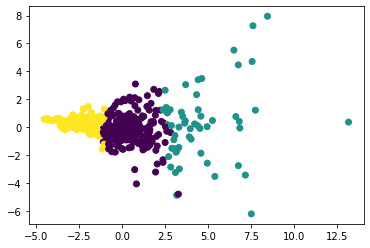

In [360]:

robust_scaler = RobustScaler()

robust_scaler.fit(density_data)

robust_data = robust_scaler.transform(density_data)

# density_data = minmax_norm(density_data)
kmeans = KMeans(n_clusters=3, init='k-means++',max_iter=400,random_state=0)
kmeans.fit(robust_data)

basic_df = tmp_df.copy()
basic_df['km_cluster'] = kmeans.labels_

from sklearn.decomposition import PCA

basic_pca = PCA(n_components=2)
basic_pca_transformed = basic_pca.fit_transform(robust_data)

basic_df['pca_x']=basic_pca_transformed[:,0]
basic_df['pca_y']=basic_pca_transformed[:,1]

plt.scatter(x=basic_df.loc[:,'pca_x'], y=basic_df.loc[:,'pca_y'],c=basic_df['km_cluster'])


In [363]:
basic_df[basic_df['pca_y'] > 7]

,GU,DONG,POP,AREA,DENSITY,cnt,CAFE_NUM,STARBUCKS_NUM,MC_NUM,NOISE_VIBRATION_NUM,SAFE_DLVR_NUM,LEISURE_NUM,SPORT_NUM,GYM_NUM,GOLF_NUM,CAR_SHR_NUM,ANI_HSPT_NUM,교통,교육,육아,치안,건강,편의시설,km_cluster,pca_x,pca_y
DONG_CODE,,,,,,,,,,,,,,,,,,,,,,,,,,
1168060000,강남구,대치1동,24199,0.79,30632,0.0,62.5,4.0,0.25,1879.5,0.5,0.25,0.0,14.5,13.0,5.0,2.0,11.53,406.9175,23.0,92.25,83.795,42.115,1,7.595441,7.269616
1168063000,강남구,대치4동,20079,0.73,27505,0.0,62.5,4.0,0.25,1879.5,0.5,0.25,0.0,14.5,13.0,5.0,2.0,8.74,406.9175,23.0,92.25,83.795,42.115,1,8.439647,7.949694


In [375]:
a = pd.read_csv("서울시 도시계획 정비사업 현황.csv",encoding='cp949')
for i in a['위치명']:
    print(i)

신림동 808 일대
종로구 창신동 143-27
옥수동 및 신당동
해방촌
한남동~보광동
신공덕동~만리동
냉천동~현저동
창신동
서울시 성북구 길음동 498번지 일원
중구 충현동
용산구 한남동 686번지 일대
성동구 금호동4가 56-1번지 일대
성수동2가 257-2 일대
동대문구 전농동 518번지 일대
동대문구 제기동 288번지 일대
용산구 이촌동 300-25번지 일대
nan
nan
도봉구 쌍문3동 333번지
도봉구 쌍문1동 480번지
성동구 용답동 234일대
서울시 중구 신당동 321번지 일대
서울시 중구 만리동2가 10번지 일대
중구 남대문로5가 253번지 일원
광진구 구의동 122-2번지 일대
중구 봉래동1가 48-3 일원
중구 봉래동1가 57-2일원
중구 회현동1가 194-19번지 일대
중구 수표동 47-1번지 일대
송파구 오금동 143번지 일대
서대문구 홍은동 8번지 일대
중구 수표동 47-1번지 일대
오금동 143
마포구 마포동 309-1일대
마포구 아현동 662번지 일원
강남구 개포동 185번지 일대
은평구 신사동 19-190번지 일대
용산구 한강로2가 2-194호 일대
중랑구 면목동 171-7번지 일대
이문동 149-8일원
nan
nan
nan
동작구 사당동 41-17번지 일대
중화동 303-9
자양동 778-6번지 일원
자양동 680-81번지 일대
자양동 778-6번지 일원
역삼동 758번지 일대
nan
천호동 437-5번지 일원
성북구 보문동1가 196-11 일대
도동1가지내
필동 2가 지내
서울특별시 남대문 시장 일원
을지로 7가 신당동
중구 장충동 2가 200번지 산4의 34545호
신당동옥수동
관악구 봉천동 산35번지 일대
관악구 상도동 산64번지 일대
마포구 신공덕동 1번지 일대
용산구 용산동 6가 68-2
관악구 신림동 291번지 일대
성북구 동소문동 산58606616번지 일대
종로구 이화동 9 충신동 1번지 일대
관악구 신림동 산402번지 일대
영등포구 시흥동 100-1번지 일대
관악구 신림동 산79번지 일대
종로구 명륜3가 산3~15번

성북구 장위동 85 일원
성북구 장위동 238-83 일원
성북구 장위동 68-37 일원
성북구 장위동 231-233 일원
성북구 장위동 232-17 일원
성북구 길음동 1273번지 일대
서대문구 연희동 520번지 일대
태평로 2가동 120번지
동대문구 답십리동 1번지일대
동대문구 전농1동 440-9호 일대
동대문구 전농4동 204번지 일대
동대문구 답십리3동 473번지 일대
동대문구 답십리1동 178번지 일대
동대문구 답십리1동 98번지 일대
동대문구 답십리동 25번지 일대
동대문구 전농동 295-29호
은평구 응암동 419번지 일대
성동구 옥수동 526번지 일대
동대문구 신설동 92-5번지 일대
성동구 금호2가 200번지 일대
마포구 공덕동 437-30
동대문구 답십리동 465번지일대
성북구 석관동 338-540일대
성북구 보문동 3가 225번지 일대
성동구 금호동 501번지 일원
용산구 한강로 3가 63번지 일대
회현동 2가 18-1번지 일대
성북구 동소문동 7가 32번지 일대
동대문구 전농동  440-9번지 일대
동대문구 답십리동  178번지 일대
영등포구 신길2동 179번지  일대
영등포구 신길2동 186번지 일대
영등포구 영등포동 585번지  일대
영천동 69-20번지 일대
성동구 행당동 337번지 일대
성북구 길음동 612-10번지일대
영등포구 대림동 886-12 일대
마포구 합정동 418-1 일원
마포구 신공덕동 148-134번지 일대
마포구 신공덕동 148-134번지 일대
마포구 대흥동 60번지 일대
영등포구 문래동2가 35번지
영등포구 문래동 1가 70-1번지일원 문래동2가 14-84번지일원 문래동4가 23-6번지 일원
동작구 흑석동 158번지 일대
동작구 흑석동 67번지일대
서대문구 충정로3가 281-18번지 일대
은평구 수색동 361번지 일대
중랑구 상봉동 73-10번지 일대
은평구 녹번동 41953번지 일대
은평구 녹번동 53번지 일대
nan
동작구 상도동 36-1번지 일대
서대문구 홍은동 8-235번지 일대
성북구 장위동 25-55 일대

성북구 동소문동2가 33번지 일대
마포구 염리동 45번지 일원
종로구 인사동 161대
종로구 인사동 154-10대
종로구 인사동 262번지 일대
종로구 인사동 143대
종로구 인사동 153-3대
종로구 인사동 138-2대
서대문구 홍은동 104-4번지
은평구 불광동 23번지
마포구 마포동 309-1번지 일대
성동구 옥수동 526번지 일대
금천구 시흥동 789번지 외 8필지
구로구 고척동 155-2 일대
구로구 가리봉동 25번지 일대
광진구 구의동 122-2번지 일대
구로구 가리봉동 25번지 일대
구로구 가리봉동 25번지 일대
강서구 염창동 277-24번지 일대
강서구 화곡동 내발산동 일대
구로구 구로동 739번지 일대8
구로구 구로동 765번지 일대
도봉구 도봉동 92번지 일대
강동구 오금동 396번지 일대
강동구 천호동 430-21번지 일대
강동구 천호동 454-1번지 일대
강동구 천호동 409-3번지 일대
nan
노원구 중계동 421번지 일대
서울 노원구 상계동 79번지 일원
강동구 천호동 451번지 일대
은평구 불광동 산42번지 일원
은평구 녹번동 산1번지 일원
신길동 179번지일원
마천동 175번지 일대
노원구 중계동 440-66일대
노원구 중계동 440-66 일대
양천구 신정동 126 131번지 일대
서초구 방배동 541-2 일대
강남구 개포1동 660-3번지 일원
구로구 오류1동 14-280번지 일대
노원구 상계동 197-10번지 일대
서울 송파구 거여동 266번지 일원
강북구 수유동 486번지 일대
서울 강동구 하일동 304-2번지 일원
서울 관악구 신림12동 732-5번지 일원
강동구 천호동 153일대
구로구 구로동 125번지 일대
서울 구로구 구로동 125번지 일대
강북구 미아동 61-79번지 일대
서초구 방배동 1028-1번지 일대
노원구 상계동 71번지 일원
서울 도봉구 미아2동 791번지 일원
서울 도봉구 도봉동 86번지 일원
성동구 중곡4동 산3-60 일대
노원구 중계동 421 일대
신도림동 362번지일대
강남구 도곡동 872번지 일대


In [370]:
list(a['위치명'].values)

['신림동 808 일대',
 '종로구 창신동 143-27',
 '옥수동 및 신당동',
 '해방촌',
 '한남동~보광동',
 '신공덕동~만리동',
 '냉천동~현저동',
 '창신동',
 '서울시 성북구 길음동 498번지 일원',
 '중구 충현동',
 '용산구 한남동 686번지 일대',
 '성동구 금호동4가 56-1번지 일대',
 '성수동2가 257-2 일대',
 '동대문구 전농동 518번지 일대',
 '동대문구 제기동 288번지 일대',
 '용산구 이촌동 300-25번지 일대',
 nan,
 nan,
 '도봉구 쌍문3동 333번지',
 '도봉구 쌍문1동 480번지',
 '성동구 용답동 234일대',
 '서울시 중구 신당동 321번지 일대',
 '서울시 중구 만리동2가 10번지 일대',
 '중구 남대문로5가 253번지 일원',
 '광진구 구의동 122-2번지 일대',
 '중구 봉래동1가 48-3 일원',
 '중구 봉래동1가 57-2일원',
 '중구 회현동1가 194-19번지 일대',
 '중구 수표동 47-1번지 일대',
 '송파구 오금동 143번지 일대',
 '서대문구 홍은동 8번지 일대',
 '중구 수표동 47-1번지 일대',
 '오금동 143',
 '마포구 마포동 309-1일대',
 '마포구 아현동 662번지 일원',
 '강남구 개포동 185번지 일대',
 '은평구 신사동 19-190번지 일대',
 '용산구 한강로2가 2-194호 일대',
 '중랑구 면목동 171-7번지 일대',
 '이문동 149-8일원',
 nan,
 nan,
 nan,
 '동작구 사당동 41-17번지 일대',
 '중화동 303-9',
 '자양동 778-6번지 일원',
 '자양동 680-81번지 일대',
 '자양동 778-6번지 일원',
 '역삼동 758번지 일대',
 nan,
 '천호동 437-5번지 일원',
 '성북구 보문동1가 196-11 일대',
 '도동1가지내',
 '필동 2가 지내',
 '서울특별시 남대문 시장 일원',
 '을지로 7가 신당동',
 '중구 장충동 2가 200번지 산4